# Binary Classification
This exercise was done in 2018 as a take home test for a data science internship.

### Objective
Predict if a customer will subscribe to a term deposit in a direct marketing campaign of a Portuguese banking institution.

### Data Source
[Bank Marketing Data set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) 

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
plt.rc("font", size = 18)

# allow plots to appear within the notebook
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Step 1: Data Understanding

In [2]:
# read in training dataset and examine its dimension
trainset = pd.read_csv('./bank_deposit_term.csv',sep=';')
trainset.shape

(28831, 21)

In [3]:
# preliminary look at training dataset
trainset.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,50,blue-collar,single,basic.4y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
1,51,services,married,professional.course,unknown,no,no,telephone,may,mon,...,5,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
2,46,technician,divorced,professional.course,no,yes,no,cellular,may,mon,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
3,46,admin.,single,university.degree,no,yes,no,telephone,jun,mon,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
4,25,services,single,high.school,no,no,no,cellular,may,thu,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,yes


In [4]:
# helper function to list descriptive statistics for each variable
def examine_dataframe(df):
    for name in df.columns:
        print ("-----------------------------------")
        if df[name].dtype is np.dtype('O'):
            print (df[name].value_counts())
        else:
            print (df[name].describe())

In [5]:
# descriptive statistics of each variable in training dataset
examine_dataframe(trainset)

-----------------------------------
count    28831.000000
mean        40.011550
std         10.393815
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64
-----------------------------------
admin.           7294
blue-collar      6452
technician       4754
services         2797
management       2063
retired          1213
entrepreneur      996
self-employed     962
housemaid         739
unemployed        710
student           611
unknown           240
Name: job, dtype: int64
-----------------------------------
married     17437
single       8142
divorced     3194
unknown        58
Name: marital, dtype: int64
-----------------------------------
university.degree      8518
high.school            6690
basic.9y               4218
professional.course    3679
basic.4y               2865
basic.6y               1615
unknown                1234
illiterate               12
Name: education, dtype: int64
------------

One main observation from the above is the distribution of y in the training dataset is very imbalanced - no. of "yes" is only at about **11% (minority)** as compared to **89% of "no" (majority)**. Caution has to be taken in model building and evaluation, further details follow.

In [6]:
# check for missing value in training dataset
trainset.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
# since y is highly imbalanced, it may be good to see how each numerical variable varies with y
trainset.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.901575,220.148732,2.621741,983.242153,0.134777,0.245671,93.603019,-40.596271,3.805555,5175.936712
yes,40.877771,553.947352,2.051416,787.742919,0.501232,-1.204618,93.363428,-39.776385,2.150807,5095.940887


Few observations:
1. Clients who subscribed to the term deposit are of the average age of 41, whereas those that did not subscribe are slightly younger.
2. The duration of last contact with client seems to suggest, the longer the duration the more likely it is client will subscribe. It is reflective of actual scenario as longer conversation will take place if there is interest from client on the product offered.
3. The numbers in variable "pdays" need to further looked into as there are many instances of 999 - which represents no contact were previously made to a client.

Text(0,0.5,'Frequency')

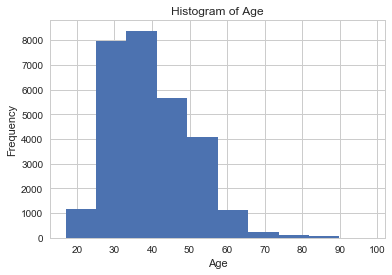

In [8]:
# plot histogram for variable "age"
trainset.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Majority of the client base in the bank belongs to **age group between 30 - 40**.

Text(0,0.5,'Frequency of Subscription')

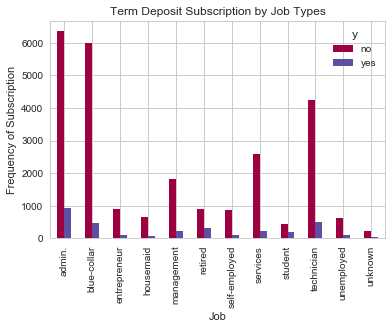

In [9]:
# several categorical variables are selected to examine how each of their distribution varies with y
# firstly, "job" variable
pd.crosstab(trainset.job, trainset.y).plot(kind='bar', colormap='Spectral')
plt.title('Term Deposit Subscription by Job Types')
plt.xlabel('Job')
plt.ylabel('Frequency of Subscription')

Amongst the different types of occupations, a larger proportion of clients work in **admin**, **blue-collar** and **technician** jobs. It is also observed that clients who have **retired** are more inclined to purchase term deposit, attributed by its higher proportion (comparing retiree who subscribed and did not subscribe to term deposit). 

Text(0,0.5,'Frequency of Subscription')

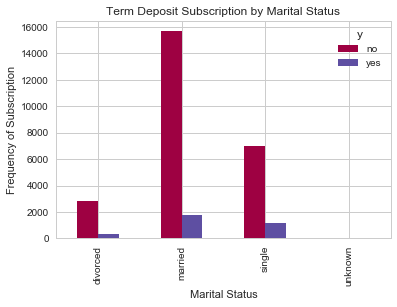

In [10]:
# "marital" variable
pd.crosstab(trainset.marital, trainset.y).plot(kind='bar', colormap='Spectral')
plt.title('Term Deposit Subscription by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Frequency of Subscription')

Most of the clients are **married**. Clients who are **single** seem to be more inclined to subscribing term deposit. One of the reasons could be married couples tend to have more economic responsibilities (housing, children's education, etc.) and may not be willing to lock in substantial amount of money as term deposit.

Text(0,0.5,'Frequency of Subscription')

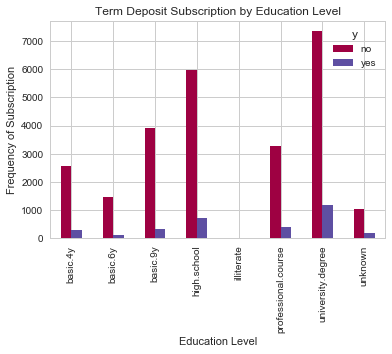

In [11]:
# "education" variable
pd.crosstab(trainset.education, trainset.y).plot(kind='bar', colormap='Spectral')
plt.title('Term Deposit Subscription by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Frequency of Subscription')

Clients in the bank have varying education level. Clients with **university degree** subscribed more to term deposit. Most entry-level employees now hold a degree and command good salaries, thus leading to more allowance to set aside some monies to be put as term deposit (with higher interest rate as compared to normal savings) for future savings.

Text(0,0.5,'Frequency of Subscription')

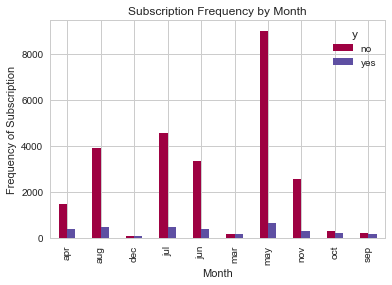

In [12]:
# "month" variable
pd.crosstab(trainset.month,trainset.y).plot(kind='bar', colormap='Spectral')
plt.title('Subscription Frequency by Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Subscription')

The spike in May seems to suggest there was a marketing campaign or product launch held, where more clients have been reached out, leading to higher subscription as compared to other months. Note that there is no data in January and February.

Text(0,0.5,'Frequency of Subscription')

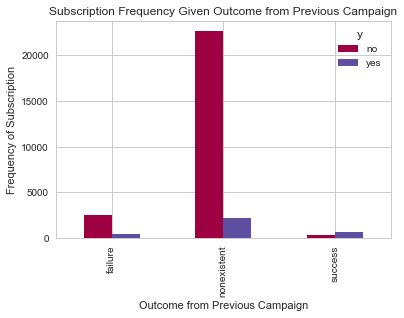

In [13]:
# "poutcome" variable
pd.crosstab(trainset.poutcome,trainset.y).plot(kind='bar', colormap='Spectral')
plt.title('Subscription Frequency Given Outcome from Previous Campaign')
plt.xlabel('Outcome from Previous Campaign')
plt.ylabel('Frequency of Subscription')

Most clients have not been approached before in previous campaign. A different product may have been launched in previous campaign and these clients are not targeted for marketing. They are the targeted clients in this campaign for term deposit and thus more subscriptions resulted from this group of clients.

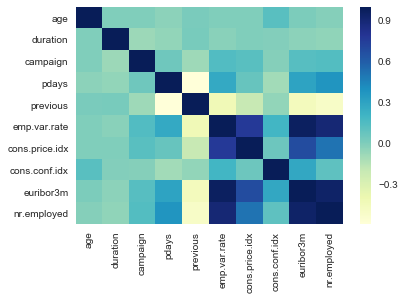

In [14]:
# check for any significant correlation between numerical variables
corr = trainset.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap="YlGnBu")

From the above plot, most of the numerical variables seem alright. The variable "previous" and "pdays" are quite negatively correlated, these variables are further studied for feature engineering in the next section.

## Step 2: Feature Engineering

In [15]:
# change binary y into numeric "0" and "1"
trainset['y'] = trainset.y.map({'no':0, 'yes':1})

In [16]:
# recategorise levels in "education" variable
trainset['education']=np.where(trainset['education'] =='basic.9y', 'basic', trainset['education'])
trainset['education']=np.where(trainset['education'] =='basic.6y', 'basic', trainset['education'])
trainset['education']=np.where(trainset['education'] =='basic.4y', 'basic', trainset['education'])
trainset['education'].unique()

array(['basic', 'professional.course', 'university.degree', 'high.school',
       'unknown', 'illiterate'], dtype=object)

In [17]:
# create 2 new variables as it is discovered within the training dataset, where client who has not been contacted before (indicated as 999 in "pdays" and 0 in "previous") is "nonexistent" in "poutcome".
# by doing so, the columns "pdays" and "poutcome_nonexistent" can be eliminated

# variable "new" - client that has not been contacted before on previous campaigns
# variable "recent_prev" - client that has been contacted before recently in a previous campaign

trainset['new'] = 0
trainset['recent_prev'] = 0
trainset.loc[(trainset['previous'] == 0) & (trainset['pdays'] == 999) ,'new'] = 1
trainset.loc[trainset['pdays'] < 999,'recent_prev'] = 1

In [18]:
# one-hot encoding to transform all categorical variables to numerical variables
cat_vars=['job','marital','education','default','housing','loan','contact','month','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(trainset[var], prefix=var)
    train_dummy = trainset.join(cat_list)
    trainset = train_dummy
    
train_vars = trainset.columns.values.tolist()
train_keep = [i for i in train_vars if i not in cat_vars]
train_final = trainset[train_keep]

# remove unwanted columns in training dataset
# column "default_yes" is dropped as there are only 3 instances in training set and 0 instance in test set.
train_final.drop(['day_of_week', 'pdays', 'job_unknown', 'marital_unknown', 'education_unknown', 'default_yes','poutcome_nonexistent'], axis=1, inplace=True)

C:\Users\Jolyn\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [19]:
train_final.head(5)

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success
0,50,152,2,0,1.1,93.994,-36.4,4.860,5191.0,0,...,0,0,0,0,1,0,0,0,0,0
1,51,158,5,0,1.1,93.994,-36.4,4.858,5191.0,0,...,0,0,0,0,1,0,0,0,0,0
2,46,214,2,0,-1.8,92.893,-46.2,1.244,5099.1,0,...,0,0,0,0,1,0,0,0,0,0
3,46,24,1,0,1.4,94.465,-41.8,4.961,5228.1,0,...,0,0,1,0,0,0,0,0,0,0
4,25,646,5,0,-1.8,92.893,-46.2,1.266,5099.1,1,...,0,0,0,0,1,0,0,0,0,0


In [20]:
train_final.columns.values

array(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'new', 'recent_prev', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_unknown', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_success'], dtype=object)

In [21]:
# read in testing dataset and examine its dimension
testset = pd.read_csv('./bank_deposit_term_test.csv',sep=';')
testset.shape

(12357, 20)

In [22]:
testset.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,49,technician,divorced,unknown,no,no,no,telephone,jun,wed,41,1,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
1,56,blue-collar,married,basic.9y,unknown,yes,no,telephone,may,thu,151,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0
2,35,technician,single,professional.course,no,no,no,telephone,jun,fri,397,1,999,0,nonexistent,1.4,94.465,-41.8,4.947,5228.1
3,32,blue-collar,married,basic.9y,unknown,no,no,telephone,may,fri,180,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0
4,27,unknown,single,university.degree,no,yes,no,cellular,jun,wed,665,4,3,2,success,-1.7,94.055,-39.8,0.767,4991.6
5,33,technician,single,professional.course,no,no,yes,telephone,jun,fri,241,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1
6,22,services,single,high.school,no,yes,no,cellular,jul,fri,143,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1
7,58,management,married,university.degree,no,yes,yes,cellular,may,fri,256,1,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1
8,33,admin.,married,high.school,unknown,yes,no,cellular,aug,tue,68,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
9,38,admin.,married,university.degree,no,no,no,telephone,jun,mon,757,2,999,0,nonexistent,1.4,94.465,-41.8,4.960,5228.1


In [23]:
# descriptive statistics of each variable in testing dataset
examine_dataframe(testset)

-----------------------------------
count    12357.000000
mean        40.053249
std         10.485345
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         98.000000
Name: age, dtype: float64
-----------------------------------
admin.           3128
blue-collar      2802
technician       1989
services         1172
management        861
retired           507
entrepreneur      460
self-employed     459
housemaid         321
unemployed        304
student           264
unknown            90
Name: job, dtype: int64
-----------------------------------
married     7491
single      3426
divorced    1418
unknown       22
Name: marital, dtype: int64
-----------------------------------
university.degree      3650
high.school            2825
basic.9y               1827
professional.course    1564
basic.4y               1311
basic.6y                677
unknown                 497
illiterate                6
Name: education, dtype: int64
----------------

The descriptive statistics of variables in testing dataset are similar to that in training dataset. **The only anomaly observed is there is no client who has defaulted credit in testing dataset.** Thus, the column "default_yes" in training dataset needs to be dropped to enable modelling to be done.

In [24]:
# recategorise levels in "education" variable, as that done with training set
testset['education']=np.where(testset['education'] =='basic.9y', 'basic', testset['education'])
testset['education']=np.where(testset['education'] =='basic.6y', 'basic', testset['education'])
testset['education']=np.where(testset['education'] =='basic.4y', 'basic', testset['education'])
testset['education'].unique()

# create new variables - "new" and "recent_prev", as that done with training set
testset['new'] = 0
testset['recent_prev'] = 0
testset.loc[(testset['previous'] == 0) & (testset['pdays'] == 999) ,'new'] = 1
testset.loc[testset['pdays'] < 999,'recent_prev'] = 1

In [25]:
# one-hot encoding to transform all categorical variables to numerical variables
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(testset[var], prefix=var)
    test_dummy = testset.join(cat_list)
    testset = test_dummy

test_vars = testset.columns.values.tolist()
test_keep = [i for i in test_vars if i not in cat_vars]
test_final = testset[test_keep]

# remove unwanted columns, as that done with training set
test_final.drop(['day_of_week', 'pdays', 'job_unknown', 'marital_unknown', 'education_unknown', 'poutcome_nonexistent'], axis=1, inplace=True)
test_final.columns.values

C:\Users\Jolyn\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


array(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'new', 'recent_prev', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management',
       'job_retired', 'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_unknown', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_success'], dtype=object)

In [26]:
test_final.head(10)

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,new,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_success
0,49,41,1,0,1.4,94.465,-41.8,4.959,5228.1,1,...,0,0,1,0,0,0,0,0,0,0
1,56,151,2,0,1.1,93.994,-36.4,4.860,5191.0,1,...,0,0,0,0,1,0,0,0,0,0
2,35,397,1,0,1.4,94.465,-41.8,4.947,5228.1,1,...,0,0,1,0,0,0,0,0,0,0
3,32,180,2,0,1.1,93.994,-36.4,4.855,5191.0,1,...,0,0,0,0,1,0,0,0,0,0
4,27,665,4,2,-1.7,94.055,-39.8,0.767,4991.6,0,...,0,0,1,0,0,0,0,0,0,1
5,33,241,3,0,1.4,94.465,-41.8,4.959,5228.1,1,...,0,0,1,0,0,0,0,0,0,0
6,22,143,2,0,1.4,93.918,-42.7,4.963,5228.1,1,...,0,1,0,0,0,0,0,0,0,0
7,58,256,1,0,-1.8,92.893,-46.2,1.250,5099.1,1,...,0,0,0,0,1,0,0,0,0,0
8,33,68,1,0,1.4,93.444,-36.1,4.963,5228.1,1,...,0,0,0,0,0,0,0,0,0,0
9,38,757,2,0,1.4,94.465,-41.8,4.960,5228.1,1,...,0,0,1,0,0,0,0,0,0,0


## Step 3: Model Building

In [27]:
# create X (features) and y (response)
X = train_final.drop(['y'], axis=1, inplace=False)
y = train_final.y
print(X.shape)
print(y.shape)

(28831, 52)
(28831,)


In [28]:
from sklearn.linear_model import LogisticRegression
# from sklearn.cross_validation import cross_val_score
# stratified sampling is used by default in cross_val_score to sample training data in proportion to their classes
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [29]:
# as there is no true label (y) in testing dataset, the training dataset is split into 3:1 (train:test) in proportion, stratified by y in training dataset, for model evaluation purpose
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state = 123)

In [30]:
y_train.value_counts()

0    19187
1     2436
Name: y, dtype: int64

In [31]:
y_test.value_counts()

0    6396
1     812
Name: y, dtype: int64

In [32]:
# define a function that calculates the metrics of interest

def get_results(classifier, X_train, y_train, X_test, y_test):
    # fit classifier
    classifier.fit(X_train, y_train)
    
    # make class predictions for X_test
    y_pred_class = classifier.predict(X_test)
    
    # store the predicted probabilities for class 1
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    
    # print confusion matrix of its predictions
    print('Confusion matrix: \n', metrics.confusion_matrix(y_test, y_pred_class))
    
    # print Sensitivity (True Positive Rate) - When the actual value is positive, how often is the prediction correct?
    print('Sensitivity: ', metrics.recall_score(y_test, y_pred_class))
    
    # print Precision - When a positive value is predicted, how often is the prediction correct?
    print('Precision: ', metrics.precision_score(y_test, y_pred_class))
    
    # print AUC - percentage of ROC plot that is underneath the curve
    print('AUC: ', metrics.roc_auc_score(y_test, y_pred_prob))
    
    # plot ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve for classifier')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

#### Model 1: Logistic Regression (default parameters)

Confusion matrix: 
 [[6222  174]
 [ 500  312]]
Sensitivity:  0.384236453202
Precision:  0.641975308642
AUC:  0.923290649636


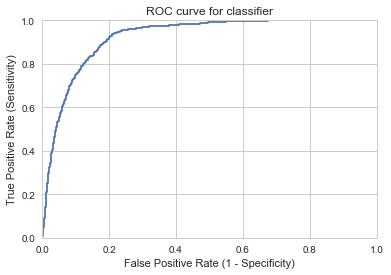

In [33]:
lg_1 = LogisticRegression()
lg_1_results = get_results(lg_1, X_train, y_train, X_test, y_test)

#### Model 1.1: Logistic Regression (class_weight = 'balanced')

Confusion matrix: 
 [[5463  933]
 [ 110  702]]
Sensitivity:  0.864532019704
Precision:  0.429357798165
AUC:  0.930499203628


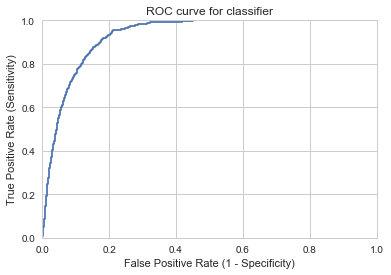

In [34]:
lg_2 = LogisticRegression(class_weight='balanced')
lg_2_results = get_results(lg_2, X_train, y_train, X_test, y_test)

#### Model 1.2: Under-sampling and Logistic Regression

In [35]:
from sklearn.utils import resample

# Separate majority and minority classes
df_merged =pd.concat([X_train, y_train], axis=1)

df_merged_majority = df_merged[df_merged.y==0]
df_merged_minority = df_merged[df_merged.y==1]
 
# Downsample majority class
df_merged_majority_downsampled = resample(df_merged_majority,replace=False,n_samples=2436,random_state=25)
 
# Combine minority class with downsampled majority class
df_merged_downsampled = pd.concat([df_merged_majority_downsampled, df_merged_minority])
 
# Display new class counts
df_merged_downsampled.y.value_counts()

1    2436
0    2436
Name: y, dtype: int64

In [36]:
y_merged = df_merged_downsampled.y
X_merged = df_merged_downsampled.drop('y', axis=1)

In [37]:
print(X_merged.shape)
print(y_merged.shape)

(4872, 52)
(4872,)


Confusion matrix: 
 [[5449  947]
 [ 116  696]]
Sensitivity:  0.857142857143
Precision:  0.423615337797
AUC:  0.928910117777


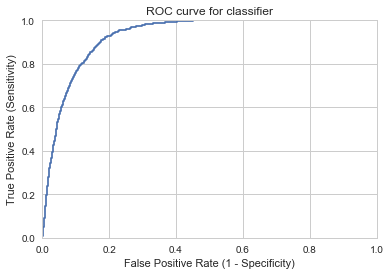

In [38]:
lg_3_results = get_results(lg_1, X_merged, y_merged, X_test, y_test)

#### Model 1.3: Logistic Regression without "duration"

In [39]:
X_train_dur = X_train.drop('duration', axis=1)
X_test_dur = X_test.drop('duration', axis=1)
print(X_train_dur.shape)
print(X_test_dur.shape)

(21623, 51)
(7208, 51)


Confusion matrix: 
 [[6295  101]
 [ 634  178]]
Sensitivity:  0.21921182266
Precision:  0.637992831541
AUC:  0.772932378457


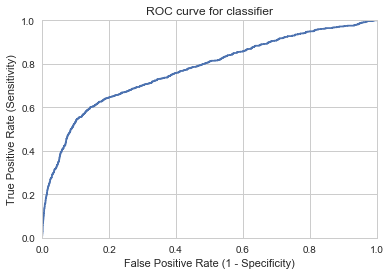

In [40]:
lg_4_results = get_results(lg_1, X_train_dur, y_train, X_test_dur, y_test)

#### Model 1.4: Logistic Regression without variables with importance < 0.01

In [41]:
X_train_lean = X_train.drop(['job_entrepreneur','job_housemaid','job_retired','job_self-employed','job_student','job_unemployed','education_illiterate','housing_unknown','loan_unknown','month_apr','month_aug','month_dec','month_jul','month_jun','month_mar','month_nov','month_sep','poutcome_failure'], axis=1)
X_test_lean = X_test.drop(['job_entrepreneur','job_housemaid','job_retired','job_self-employed','job_student','job_unemployed','education_illiterate','housing_unknown','loan_unknown','month_apr','month_aug','month_dec','month_jul','month_jun','month_mar','month_nov','month_sep','poutcome_failure'], axis=1)
print(X_train_lean.shape)
print(X_test_lean.shape)

(21623, 34)
(7208, 34)


Confusion matrix: 
 [[6200  196]
 [ 486  326]]
Sensitivity:  0.401477832512
Precision:  0.624521072797
AUC:  0.923954164703


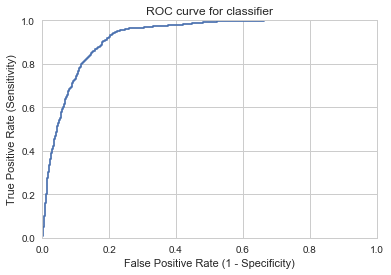

In [42]:
lg_5_results = get_results(lg_1, X_train_lean, y_train, X_test_lean, y_test)

#### Model 2: Random Forest (n_estimators = 1000)

In [43]:
from sklearn.ensemble import RandomForestClassifier

Confusion matrix: 
 [[6166  230]
 [ 438  374]]
Sensitivity:  0.460591133005
Precision:  0.619205298013
AUC:  0.932867043596


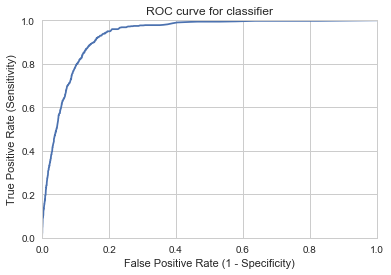

In [44]:
rf_1 = RandomForestClassifier(n_estimators=1000, random_state=123)
rf_1_results = get_results(rf_1, X_train, y_train, X_test, y_test)

#### Model 2.1: Random Forest (with class_weight = 'balanced')

Confusion matrix: 
 [[6201  195]
 [ 478  334]]
Sensitivity:  0.411330049261
Precision:  0.631379962193
AUC:  0.933657735592


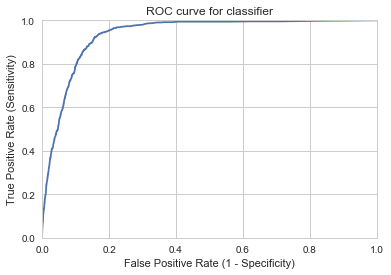

In [45]:
rf_2 = RandomForestClassifier(n_estimators=1000, class_weight ='balanced', random_state=123)
rf_2_results = get_results(rf_2, X_train, y_train, X_test, y_test)

Text(0.5,0,'Relative Importance')

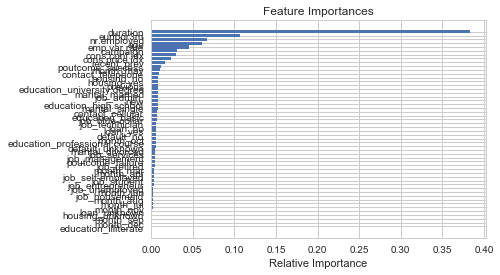

In [46]:
features = X_train.columns[0:53]
importances = rf_2.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [47]:
# Get numerical feature importances

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:30} Importance:{}'.format(*pair)) for pair in feature_importances]

Variable: duration                       Importance:0.38
Variable: euribor3m                      Importance:0.11
Variable: nr.employed                    Importance:0.07
Variable: age                            Importance:0.06
Variable: emp.var.rate                   Importance:0.05
Variable: campaign                       Importance:0.03
Variable: cons.conf.idx                  Importance:0.03
Variable: cons.price.idx                 Importance:0.02
Variable: recent_prev                    Importance:0.02
Variable: previous                       Importance:0.01
Variable: new                            Importance:0.01
Variable: job_admin.                     Importance:0.01
Variable: job_blue-collar                Importance:0.01
Variable: job_services                   Importance:0.01
Variable: job_technician                 Importance:0.01
Variable: marital_divorced               Importance:0.01
Variable: marital_married                Importance:0.01
Variable: marital_single       

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Model 2.2: Under-sampling and Random Forest

Confusion matrix: 
 [[5340 1056]
 [  76  736]]
Sensitivity:  0.906403940887
Precision:  0.410714285714
AUC:  0.930268436708


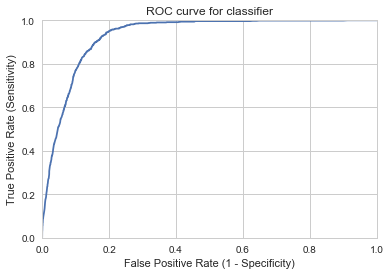

In [48]:
rf_3_results = get_results(rf_1, X_merged, y_merged, X_test, y_test)

#### Model 2.3: Random Forest without "duration"

Confusion matrix: 
 [[6173  223]
 [ 576  236]]
Sensitivity:  0.290640394089
Precision:  0.514161220044
AUC:  0.762778152602


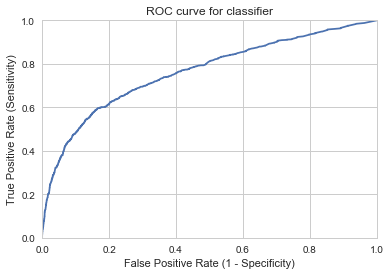

In [49]:
rf_4_results = get_results(rf_1, X_train_dur, y_train, X_test_dur, y_test)

#### Model 2.4: Random Forest without variables with importance < 0.01

Confusion matrix: 
 [[6157  239]
 [ 438  374]]
Sensitivity:  0.460591133005
Precision:  0.610114192496
AUC:  0.933526804006


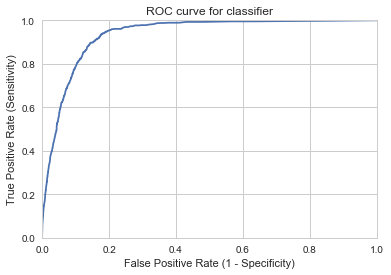

In [50]:
rf_5_results = get_results(rf_1, X_train_lean, y_train, X_test_lean, y_test)

### Discussion:
1. Several models have been built with mainly 2 algorithms (Logistic Regression and Random Forest) to evaluate performances under different settings:
>* default parameters of Logistic Regression (LR) and Random Forest (RF). For RF, n_estimators of 1000 and 500 had been attempted as the training dataset volume is substantial (28831 rows x 52 columns), 1000 is chosen since it provides better performance.
>* since dependent variable y is highly imbalanced, one way to address in modelling is by specifying parameter "class_weight" to 'balanced' so that higher weightage will be given to minority in y.
>* another method to address imbalanced data is by performing under-sampling on training dataset. Under-sampling is chosen instead of over-sampling due to the very samples of "1" in y. Should over-sampling is done, the instances of "1" to be synthesized would be overwhelming to balance the 89% of "0" in y variable.
>* the variable "duration" is excluded from modelling. Duration refers to the last contact duration with client. This variable would only be made available after the action of contacting a client is performed. Building a model with this variable included may not generalise well to unseen data in the future. Thus, it should not be considered in coming up with a predictive model that will be used in future work.
>* based on features importance extracted from Random Forest, the models can be fine tuned by only including features with higher prediction power and exclude features that do not contribute to modelling.

2. In terms of metrics used for model evaluation, **Accuracy** is **not** tracked for it would not be reflective (it'll always be high with predicted outcome mostly "0"s) since the outcome of focus in the dataset is highly imbalanced. The instances of False Negative (FN) matter in this business problem - where a client who is predicted to not subscribe actually subscribed to term deposit in real - the number of FN needs to be optimised to be lowest possible as we do not want to miss targeting these customers who will potentially buy our product. Thus, **Sensitivity** and **Precision** are monitored to ensure predicted positive outcome "1" is indeed accurate. **AUC**, Area Under the ROC curve, is the chosen metric for model selection.<br>
<br>
3. Table below shows the results compiled from the different permutations modelled above.<br>
<img src="Capture2.PNG" title="Collation of Model Results" /> <br>

4. Based on features importance extracted from Random Forest, the variable "duration" is the most important variable. Removing it from the models resulted in substantial reduction in model performance, AUC reduced by approximately 16% and 18% for LR and RF respectively, whilst Sensitivity dropped by 43% and 37% respectively. As the variable "duration" is provided in testing dataset, the variable will be retained to provide stronger predictions for testing dataset. **However, for true future prediction purpose, this variable should be removed in modelling since future testing data would not have this variable available.**<br>
<br>
5. Generally, Random Forest performed better than Logistic Regression on each tested scenario. Although under-sampling performed rather well and comparable to the model with parameter "class_weight" set to 'balanced', the resulting sample size in under-sampling might be too small (4872 rows) to generalise to testing dataset (12357 rows).<br>
<br>
6. Based on the results obtained, Random Forest with class_weight set as 'balanced' has the highest AUC and will be deployed for prediction on testing dataset.

## Step 4: Score Testing Dataset

In [51]:
# entire training dataset should be used to predict for testing dataset
# X (features) and y (response) from training dataset
print(X.shape)
print(y.shape)

(28831, 52)
(28831,)


In [52]:
# create X (features) and y (response) from testing dataset
X_test_final = test_final
print(X_test_final.shape)

(12357, 52)


In [53]:
# train model with Random Forest (class_weight = 'balanced')
rf_final = RandomForestClassifier(n_estimators=1000, class_weight ='balanced', random_state=123)
rf_final.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

In [54]:
# store the predicted probabilities for class 1
y_test_prob = rf_final.predict_proba(X_test_final)[:, 1]

In [55]:
# output y_test_prob into a csv file
prediction = pd.DataFrame(y_test_prob, columns=['class_1']).to_csv('bank_deposit_term_test_scoring.csv')

#prediction = pd.DataFrame(predictions, columns=['predictions']).to_csv('prediction.csv')

### Limitations and Futher Works:
1. There are many options available in dealing with imbalanced data, libraries such as SMOTE, ADASYN, Tomek's Link, etc. are offered by imbalanced-learn package in scikit-learn that can be explored.<br>
<br>
2. Only two algorithms are deployed in this exercise. If time allows, more algorithms should be attempted. Some may include XGBoost, Support Vector Machine, Neural Network. The same performance metrices should apply and lastly followed by an ensemble method by assigning different weights to good performing models in congregating as one predictive model.